# Player Similarity Scores on Many Players

Moving up, we're scaling the process described by **Player Similarity Scores**.
This abstracts many processes, so it's best to read this after the aforementioned paper!

## Abstractions

Some functions are moved to another file.
More importantly, the method of loading the scores are heavily abstracted with `PreprocessingDynamic` and `Dataset`, which are custom classes simplifying the loading process.

It implements filters:
- `unpopular_maps_thres`: Removes maps that aren't played by at least n% of the players
- `unpopular_players_thres`: Removes players that haven't played by at least n% of the maps
- `sr_min_thres`: Removes maps below this SR
- `acc_filter`: Removes scores outside this range

The result of the preprocessing is a better formatted `pd.DataFrame`

In [2]:
import warnings
from pathlib import Path

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic
from opal.score.similarity.nb_utils import similarity_pair

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.2,
    unpopular_plays_thres=0.2,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)
df, df_sim, _, qt = similarity_pair(df, min_support=40)

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 279765
by_unpopular_plays 279765 -> 75055
by_acc_filter 75055 -> 74961
by_remove_mod 74961 -> 71327
Users Left: 291 | Beatmaps Left: 718


100%|██████████| 65703/65703 [02:18<00:00, 475.25it/s]


We removed quite a few scores that didn't match our filters, but that's fine, we're working with better data!

We also generated the similarity matrix after some time, let's take a gander at it

<AxesSubplot:xlabel='user_id-year', ylabel='user_id-year'>

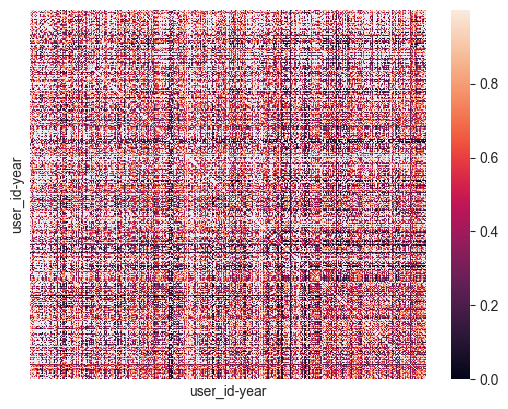

In [3]:
import seaborn as sns

sns.heatmap(df_sim, yticklabels=False, xticklabels=False)

Looks brilliant!

## Evaluation

Now, we need to evaluate how well this performs.

TL;DR: we find the prediction by taking the weighted average of scores per map that each user has played.

In order to do so:
- For each player (that exists in the similarity matrix), we:
    - Index the df with only their scores
    - Copy and create a df with their similarities of other players
    - Group by `map_id`:
        - Take the weighted average (weighted on similarity)
        - Get the support
    - Inverse Transform the `predict_qt`

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np

df_users = []
SIM_WEIGHT_POW = 8
for ix, sim in tqdm(df_sim.iterrows(), total=len(df_sim)):
    df_user = df.loc[ix].set_index('map_id')
    # Adds similarity as a column to the df
    #                        vvvv
    # +--------+--------+------------+
    # | map_id | acc_qt | similarity |
    # +--------+--------+------------+
    df_sim_user = pd.merge(
        df,
        sim.dropna().rename('similarity'),
        left_index=True, right_index=True
    )

    # Within each map, we find the weighted average (weighted by similarity)
    # +--------+--------+------------+
    # | map_id | acc_qt | similarity |
    # +--------+---^----+------^-----+
    #     (target) |           | (weights)
    #              +-----------+
    df_sim_gped = df_sim_user.groupby('map_id').apply(
        lambda g: np.average(g['accuracy_qt'], weights=g['similarity'] ** SIM_WEIGHT_POW)
    )
    # This will yield us a SINGLE prediction per map_id

    # We also COUNT the number of supports
    df_sim_supp = df_sim_user.groupby('map_id').agg('count').iloc[:, 0]

    # Join the prediction & support to the user df
    df_user = df_user.merge(df_sim_gped.rename('predict_qt'),
                            left_index=True, right_index=True)
    df_user = df_user.merge(df_sim_supp.rename('support'),
                            left_index=True, right_index=True)

    # Inverse transform the prediction_qt
    df_user['predict'] = qt.inverse_transform(df_user[['predict_qt']].to_numpy())

    df_users.append(df_user)

df_users = pd.concat(df_users)

100%|██████████| 363/363 [00:40<00:00,  8.90it/s]


### Evaluation Metrics

Let's evaluate the RMSE & R^2

In [5]:
from sklearn.metrics import r2_score, mean_squared_error


def evaluate(pred, actual):
    print(f"Accuracy MSE: {mean_squared_error(actual, pred, squared=False):.2%}")
    print(f"R^2: {r2_score(actual, pred):.2%}")


evaluate(df_users['predict'], df_users['accuracy'])

Accuracy MSE: 1.62%
R^2: 59.74%


Also, let's plot the error!

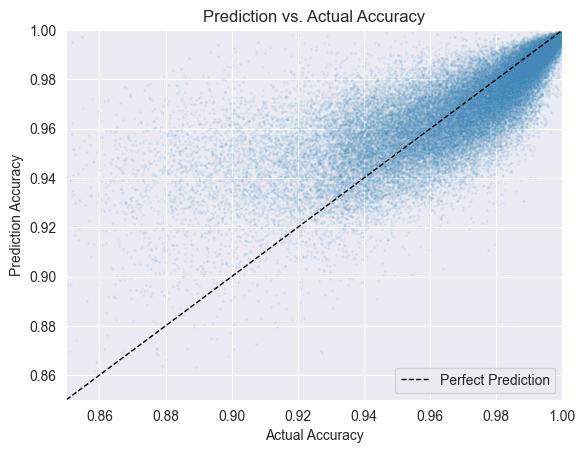

In [22]:
from matplotlib import pyplot as plt

_ = plt.plot(
    [0.85, 1], [0.85, 1],
    color='black', linestyle='dashed', linewidth=1,
    label="Perfect Prediction"
)
sns.scatterplot(
    x=df_users['accuracy'],
    y=df_users['predict'] ** 1.1,
    alpha=0.1,
    s=3,
    data=df_users
)
_ = plt.xlim(0.85, 1)
_ = plt.ylim(0.85, 1)
_ = plt.xlabel("Actual Accuracy")
_ = plt.ylabel("Prediction Accuracy")
_ = plt.title("Prediction vs. Actual Accuracy")

Accuracy MSE: 1.56%
R^2: 62.49%


## Post-Correction

Interestingly, it's curved. That means it overestimates accuracy for lower accuracies.

While much can be done to correct it, we'll stick to a power transform.

This is because many alternative prior improvements can be done before reaching this stage, thus may render this obsolete in the future.

In [28]:
for i in np.arange(1, 1.25, 0.02):
    print(f"{i:.2f}")
    evaluate(df_users['predict'] ** i, df_users['accuracy'])
    print("-" * 5)

1.00
Accuracy MSE: 1.62%
R^2: 59.74%
-----
1.02
Accuracy MSE: 1.60%
R^2: 60.52%
-----
1.04
Accuracy MSE: 1.59%
R^2: 61.19%
-----
1.06
Accuracy MSE: 1.58%
R^2: 61.74%
-----
1.08
Accuracy MSE: 1.57%
R^2: 62.17%
-----
1.10
Accuracy MSE: 1.56%
R^2: 62.49%
-----
1.12
Accuracy MSE: 1.56%
R^2: 62.70%
-----
1.14
Accuracy MSE: 1.56%
R^2: 62.80%
-----
1.16
Accuracy MSE: 1.56%
R^2: 62.78%
-----
1.18
Accuracy MSE: 1.56%
R^2: 62.65%
-----
1.20
Accuracy MSE: 1.56%
R^2: 62.41%
-----
1.22
Accuracy MSE: 1.57%
R^2: 62.05%
-----
1.24
Accuracy MSE: 1.58%
R^2: 61.59%
-----


We'll use 1.14 as it works best.

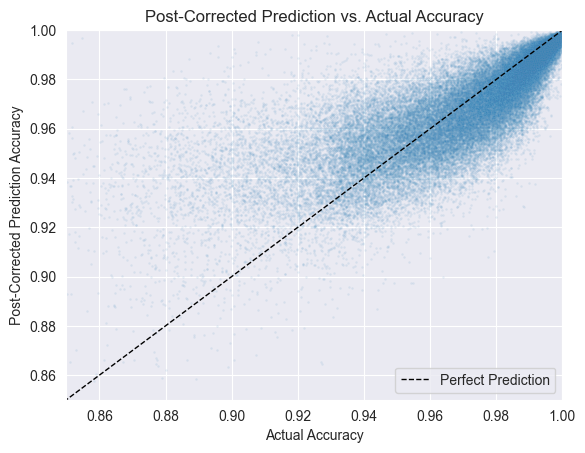

In [29]:
df_users['predict_a'] = df_users.predict ** 1.14
sns.scatterplot(
    x='accuracy',
    y='predict_a',
    alpha=0.1,
    s=3,
    data=df_users
)
_ = plt.plot([0, 1], [0, 1],
             color='black', linestyle='dashed', linewidth=1,
             label="Perfect Prediction"
             )
_ = plt.xlim(0.85, 1)
_ = plt.ylim(0.85, 1)
_ = plt.xlabel("Actual Accuracy")
_ = plt.ylabel("Post-Corrected Prediction Accuracy")
_ = plt.title("Post-Corrected Prediction vs. Actual Accuracy")
_ = plt.legend()

In [30]:
print("Pre-corrected")
print("-" * 10)
evaluate(df_users['predict'], df_users['accuracy'])
print()
print("Post-corrected")
print("-" * 10)
evaluate(df_users['predict_a'], df_users['accuracy'])

Pre-corrected
----------
Accuracy MSE: 1.62%
R^2: 59.74%

Post-corrected
----------
Accuracy MSE: 1.56%
R^2: 62.80%


Now that we've proven that it's a **FEASIBLE** pipeline, we need to evaluate it

### Unbiased Evaluation

Take a glance here, which part caused bias & overestimate in accuracy?

- The similarity estimate: it used already known scores to best fit.

These are important considerations for evaluation.
If we knew answers to a test, it's cheating;
this happens similarly here, we use the train data to evaluate.

We need to separate train & test to get an accurate assessment on its accuracy.

We'll discuss the process in another notebook :)